In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.feature_importance import mean_score_decrease

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

In [8]:
dfraw = pd.read_csv('dfraw.csv')

In [9]:
dfraw.head()

,Amount given Credit,Gender,Education,Marital Status,Age,Repayment Sep,Repayment Aug,Repayment Jul,Repayment Jun,Repayment May,...,Amount Prev Pay Jul,Amount Prev Pay Jun,Amount Prev Pay May,Amount Prev Pay Apr,Default Payment,Total Bill,Total Pay,Count Late,Mean Pay Late,Debt
0,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,1,7704,689,2,0.666667,7015
1,120000,2,2,2,26,0,2,0,0,0,...,1000,1000,0,2000,1,17077,5000,2,0.666667,12077
2,90000,2,2,2,34,0,0,0,0,0,...,1000,1000,1000,5000,0,101653,11018,0,0.000000,90635
3,50000,2,2,1,37,0,0,0,0,0,...,1200,1100,1069,1000,0,231334,8388,0,0.000000,222946
4,50000,1,2,1,57,0,0,0,0,0,...,10000,9000,689,679,0,109339,59049,0,0.000000,50290


In [10]:
df = dfraw.copy()

## Feature Engineering

### Binning

In [11]:
df['Age'].describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: Age, dtype: float64

In [12]:
#binning age berdasar kan interquartile range

df.Age = pd.cut(df.Age,[0,28,34,41,100], labels=(1,2,3,4))
df.head()

,Amount given Credit,Gender,Education,Marital Status,Age,Repayment Sep,Repayment Aug,Repayment Jul,Repayment Jun,Repayment May,...,Amount Prev Pay Jul,Amount Prev Pay Jun,Amount Prev Pay May,Amount Prev Pay Apr,Default Payment,Total Bill,Total Pay,Count Late,Mean Pay Late,Debt
0,20000,2,2,1,1,2,2,0,0,0,...,0,0,0,0,1,7704,689,2,0.666667,7015
1,120000,2,2,2,1,0,2,0,0,0,...,1000,1000,0,2000,1,17077,5000,2,0.666667,12077
2,90000,2,2,2,2,0,0,0,0,0,...,1000,1000,1000,5000,0,101653,11018,0,0.000000,90635
3,50000,2,2,1,3,0,0,0,0,0,...,1200,1100,1069,1000,0,231334,8388,0,0.000000,222946
4,50000,1,2,1,4,0,0,0,0,0,...,10000,9000,689,679,0,109339,59049,0,0.000000,50290


In [13]:
df['Age'] = df['Age'].astype('int64')

In [14]:
#berdasarkan korelasi, saya mengurangi feature yang memiliki multicol

num = ['Amount given Credit', 'Repayment Sep', 'Repayment Aug',
       'Repayment Jul', 'Repayment Jun', 'Repayment May', 'Repayment Apr',
       'Amount of Bill Sep', 'Amount of Bill Aug', 'Amount of Bill Jul',
       'Amount of Bill Jun', 'Amount of Bill May', 'Amount of Bill Apr',
       'Amount Prev Pay Sep', 'Amount Prev Pay Aug', 'Amount Prev Pay Jul',
       'Amount Prev Pay Jun', 'Amount Prev Pay May', 'Amount Prev Pay Apr',
       'Total Bill','Total Pay','Count Late','Mean Pay Late','Debt']

num1 = ['Amount given Credit','Age','Repayment Sep', 'Repayment Aug',
       'Repayment Jul', 'Repayment Jun', 'Repayment May', 'Repayment Apr',
       'Amount of Bill Sep', 'Amount of Bill Aug', 'Amount of Bill Jul',
       'Amount of Bill Jun', 'Amount of Bill May', 'Amount of Bill Apr',
       'Amount Prev Pay Sep', 'Amount Prev Pay Aug', 'Amount Prev Pay Jul',
       'Amount Prev Pay Jun', 'Amount Prev Pay May', 'Amount Prev Pay Apr',
       'Total Bill','Total Pay','Count Late','Mean Pay Late','Debt']

cat = ['Education','Marital Status','Age']
cat1 = ['Education','Marital Status']

## Dataset Splitting

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Amount given Credit  30000 non-null  int64  
 1   Gender               30000 non-null  int64  
 2   Education            30000 non-null  int64  
 3   Marital Status       30000 non-null  int64  
 4   Age                  30000 non-null  int64  
 5   Repayment Sep        30000 non-null  int64  
 6   Repayment Aug        30000 non-null  int64  
 7   Repayment Jul        30000 non-null  int64  
 8   Repayment Jun        30000 non-null  int64  
 9   Repayment May        30000 non-null  int64  
 10  Repayment Apr        30000 non-null  int64  
 11  Amount of Bill Sep   30000 non-null  int64  
 12  Amount of Bill Aug   30000 non-null  int64  
 13  Amount of Bill Jul   30000 non-null  int64  
 14  Amount of Bill Jun   30000 non-null  int64  
 15  Amount of Bill May   30000 non-null 

In [28]:
X = df.drop(columns='Default Payment')
y = df['Default Payment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24000, 28), (6000, 28), (24000,), (6000,))

## Using KNN

In [29]:
rsp.knn_params

{'algo__n_neighbors': Integer(low=1, high=40),
 'algo__weights': ['uniform', 'distance'],
 'algo__p': Real(low=1, high=2, prior='uniform')}

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min finished


{'algo__n_neighbors': 39, 'algo__p': 1.7965429868602332, 'algo__weights': 'uniform'}
0.7937004239592862 0.7562321329611139 0.7504441571464027
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.64      0.34      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.64      0.67      6000
weighted avg       0.79      0.81      0.79      6000



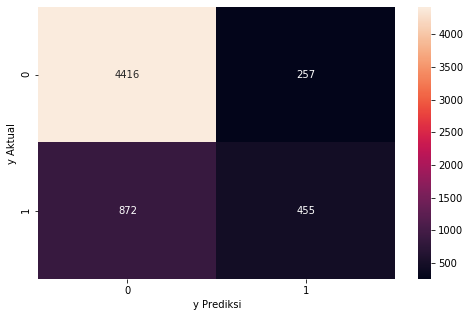

In [30]:
preprocessorknn = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), num),
    ('categoric', cat_pipe(encoder='onehot'), cat)
])

pipelineknn = Pipeline([
    ('prep', preprocessorknn),
    ('algo', KNeighborsClassifier(metric='euclidean'))
])

model1 = RandomizedSearchCV(pipelineknn, rsp.knn_params, cv=4,scoring='roc_auc', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model1.fit(X_train, y_train)

print(model1.best_params_)
print(model1.score(X_train, y_train), model1.best_score_, model1.score(X_test, y_test))

print(classification_report(y_test,model1.predict(X_test)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, model1.predict(X_test)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

## Using Logistic Regression

In [31]:
rsp.logreg_params

{'algo__fit_intercept': [True, False],
 'algo__C': Real(low=-3, high=3, prior='log-uniform')}

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.6s finished


{'algo__C': 0.17670169402947963, 'algo__fit_intercept': True}
0.7634437546376232 0.7606161149743124 0.7424659385451319
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.34      0.45      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000



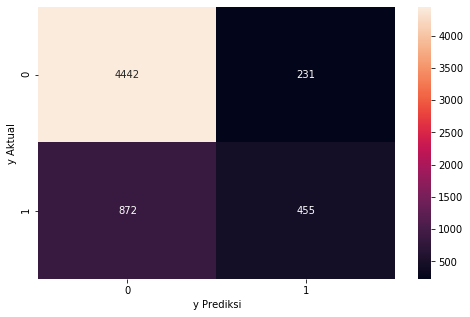

In [32]:
preprocessorlogreg = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), num),
    ('categoric', cat_pipe(encoder='onehot'), cat)
])


pipelinelogreg = Pipeline([
    ('prep', preprocessorlogreg),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])


model2 = RandomizedSearchCV(pipelinelogreg, rsp.logreg_params,scoring='roc_auc' ,cv=4, n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model2.fit(X_train, y_train)

print(model2.best_params_)
print(model2.score(X_train, y_train), model2.best_score_, model2.score(X_test, y_test))

print(classification_report(y_test,model2.predict(X_test)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, model2.predict(X_test)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

## Using Random Forest Classifier

In [33]:
rsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.2min finished


{'algo__max_depth': 80, 'algo__max_features': 0.6371651421518384, 'algo__min_samples_leaf': 19, 'algo__n_estimators': 186}
0.9094544491901729 0.7793304835238776 0.7725520317377433
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.37      0.48      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.66      0.69      6000
weighted avg       0.80      0.82      0.80      6000



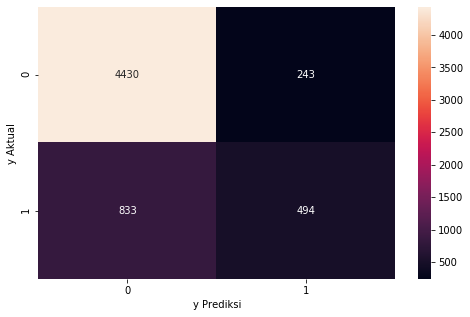

In [34]:
preprocessorrf = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), num),
    ('categoric', cat_pipe(encoder='onehot'), cat)
])

pipelinerf = Pipeline([
    ('prep', preprocessorrf),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model3 = RandomizedSearchCV(pipelinerf, rsp.rf_params, cv=4,scoring='roc_auc', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model3.fit(X_train, y_train)

print(model3.best_params_)
print(model3.score(X_train, y_train), model3.best_score_, model3.score(X_test, y_test))

print(classification_report(y_test,model3.predict(X_test)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, model3.predict(X_test)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

## Using SVC

In [19]:
rsp.svm_params

{'algo__gamma': Real(low=-3, high=3, prior='log-uniform'),
 'algo__C': Real(low=-3, high=3, prior='log-uniform')}

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   24.4s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 0.002231010801867923, 'algo__gamma': 157.41890047456675}
0.5782960129433568 0.5568936552050021 0.5043008699626242
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      4673
           1       0.34      0.01      0.02      1327

    accuracy                           0.78      6000
   macro avg       0.56      0.50      0.45      6000
weighted avg       0.68      0.78      0.69      6000



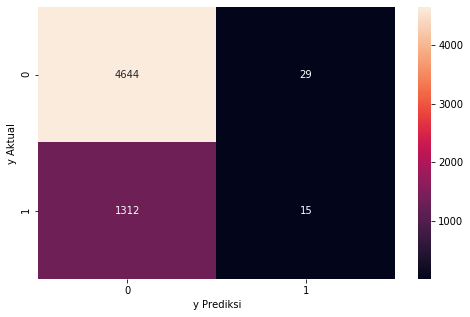

In [35]:
preprocessorsvc = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), num),
    ('categoric', cat_pipe(encoder='onehot'), cat)
])

pipelinesvc = Pipeline([
    ('prep', preprocessorsvc),
    ('algo', SVC(max_iter=500))
])

model4 = RandomizedSearchCV(pipelinesvc, rsp.svm_params, cv=4,scoring='roc_auc', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model4.fit(X_train, y_train)

print(model4.best_params_)
print(model4.score(X_train, y_train), model4.best_score_, model4.score(X_test, y_test))

print(classification_report(y_test,model4.predict(X_test)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, model4.predict(X_test)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

## Using XGBoost

In [36]:
rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.7min finished


{'algo__colsample_bytree': 0.9763799669573133, 'algo__gamma': 3, 'algo__learning_rate': 0.05820013372709852, 'algo__max_depth': 4, 'algo__n_estimators': 163, 'algo__reg_alpha': 0.07362945281639222, 'algo__reg_lambda': 2.752717392942944, 'algo__subsample': 0.6401537692938899}
0.8225296241774167 0.7851399406059784 0.7771055999842608
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.36      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



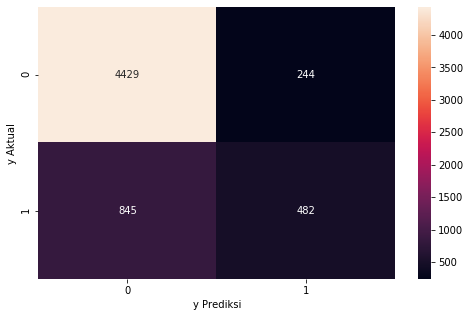

In [37]:
preprocessorxgb = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), num),
    ('categoric', cat_pipe(encoder='onehot'), cat)
])

pipelinexgb = Pipeline([
    ('prep', preprocessorxgb),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model5 = RandomizedSearchCV(pipelinexgb, rsp.xgb_params, cv=4, scoring='roc_auc', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model5.fit(X_train, y_train)

print(model5.best_params_)
print(model5.score(X_train, y_train), model5.best_score_, model5.score(X_test, y_test))

print(classification_report(y_test,model5.predict(X_test)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, model5.predict(X_test)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

f1_scoreKNN = f1_score(y_test, model1.predict(X_test))
f1_scoreLR = f1_score(y_test, model2.predict(X_test))
f1_scoreRF = f1_score(y_test, model3.predict(X_test))
f1_scoreSVC = f1_score(y_test, model4.predict(X_test))
f1_scoreXGB = f1_score(y_test, model5.predict(X_test))

precision_scoreKNN = precision_score(y_test, model1.predict(X_test))
precision_scoreLR = precision_score(y_test, model2.predict(X_test))
precision_scoreRF = precision_score(y_test, model3.predict(X_test))
precision_scoreSVC = precision_score(y_test, model4.predict(X_test))
precision_scoreXGB = precision_score(y_test, model5.predict(X_test))


recall_scoreKNN = recall_score(y_test, model1.predict(X_test))
recall_scoreLR = recall_score(y_test, model2.predict(X_test))
recall_scoreRF = recall_score(y_test, model3.predict(X_test))
recall_scoreSVC = recall_score(y_test, model4.predict(X_test))
recall_scoreXGB = recall_score(y_test, model5.predict(X_test))


accuracy_scoreKNN = accuracy_score(y_test, model1.predict(X_test))
accuracy_scoreLR = accuracy_score(y_test, model2.predict(X_test))
accuracy_scoreRF = accuracy_score(y_test, model3.predict(X_test))
accuracy_scoreSVC = accuracy_score(y_test, model4.predict(X_test))
accuracy_scoreXGB = accuracy_score(y_test, model5.predict(X_test))

model_scoreKNN = model1.score(X_test, y_test)
model_scoreLR = model2.score(X_test, y_test)
model_scoreRF = model3.score(X_test, y_test)
model_scoreSVC = model4.score(X_test, y_test)
model_scoreXGB = model5.score(X_test, y_test)

modeltrainKNN = model1.score(X_train, y_train)
modeltrainLR = model2.score(X_train, y_train)
modeltrainRF = model3.score(X_train, y_train)
modeltrainSVC = model4.score(X_train, y_train)
modeltrainXGB = model5.score(X_train, y_train)

scores = {'Model': ['KNearestNeighbors', 'Logistic Regression', 'Random Forest', 'SVC', 'XGBoost'],
          'Model Score Train': [modeltrainKNN, modeltrainLR, modeltrainRF, modeltrainSVC, modeltrainXGB],
          'Model Score Test' : [model_scoreKNN, model_scoreLR, model_scoreRF, model_scoreSVC, model_scoreXGB],
          'Precision Score': [precision_scoreKNN, precision_scoreLR, precision_scoreRF, precision_scoreSVC, precision_scoreXGB],
         'Recall Score' : [recall_scoreKNN, recall_scoreLR, recall_scoreRF, recall_scoreSVC, recall_scoreXGB],
          'f1 Score' : [f1_scoreKNN, f1_scoreLR, f1_scoreRF, f1_scoreSVC, f1_scoreXGB],
         'Accuracy Score' : [accuracy_scoreKNN, accuracy_scoreLR, accuracy_scoreRF, accuracy_scoreSVC, accuracy_scoreXGB]}


model_compare = pd.DataFrame(scores, columns=['Model', 'Model Score Train','Model Score Test', 'Precision Score', 'Recall Score', 'f1 Score', 'Accuracy Score'])
model_compare

,Model,Model Score Train,Model Score Test,Precision Score,Recall Score,f1 Score,Accuracy Score
0,KNearestNeighbors,0.793700,0.750444,0.639045,0.342879,0.446297,0.811833
1,Logistic Regression,0.763444,0.742466,0.663265,0.342879,0.452062,0.816167
2,Random Forest,0.909454,0.772552,0.670285,0.372268,0.478682,0.820667
3,SVC,0.578296,0.504301,0.340909,0.011304,0.021882,0.776500
4,XGBoost,0.822530,0.777106,0.663912,0.363225,0.469557,0.818500


Dilihat dari hasil pemodelan menggunakan hyper parameter, saya memilih model XGBoost dan Logistic Regression sebagai Base Model 

## Coba Smote untuk Handling Imbalance Target

In [41]:
from imblearn.over_sampling import SMOTE

X1 = df.drop(columns='Default Payment')
y1 = df['Default Payment']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,stratify=y, random_state=42)
print(X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(y1_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y1_train == 0))) 
  
# import SMOTE module from imblearn library 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X1_train, y1_train) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

(24000, 28) (6000, 28) (24000,) (6000,)
Before OverSampling, counts of label '1': 5309
Before OverSampling, counts of label '0': 18691 

After OverSampling, the shape of train_X: (37382, 28)
After OverSampling, the shape of train_y: (37382,) 

After OverSampling, counts of label '1': 18691
After OverSampling, counts of label '0': 18691


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.3min finished


{'algo__colsample_bytree': 0.4370861069626263, 'algo__gamma': 8, 'algo__learning_rate': 0.1575132049977973, 'algo__max_depth': 7, 'algo__n_estimators': 182, 'algo__reg_alpha': 0.0025113061677390002, 'algo__reg_lambda': 0.06870614282613305, 'algo__subsample': 0.4668543055695109}
0.9484361099009633 0.8987249067074213 0.7484615963919782
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4673
           1       0.54      0.45      0.49      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.67      0.68      6000
weighted avg       0.78      0.79      0.79      6000



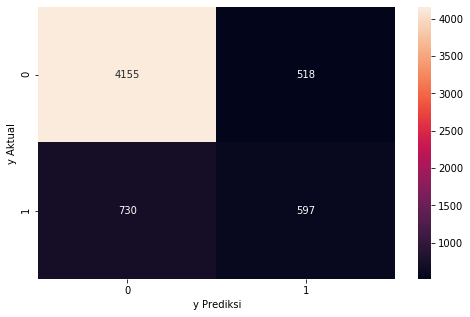

In [42]:
preprocessorxgb = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), num),
    ('categoric', cat_pipe(encoder='onehot'), cat)
])

pipelinexgb = Pipeline([
    ('prep', preprocessorxgb),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model6 = RandomizedSearchCV(pipelinexgb, rsp.xgb_params, cv=4,scoring='roc_auc', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model6.fit(X_train_res, y_train_res)

print(model6.best_params_)
print(model6.score(X_train_res, y_train_res), model6.best_score_, model6.score(X1_test, y1_test))

print(classification_report(y1_test,model6.predict(X1_test)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y1_test, model6.predict(X1_test)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.7s finished


{'algo__C': 3.907967156822884, 'algo__fit_intercept': True}
0.8773436552647375 0.8538245978673874 0.7191735105113294
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      4673
           1       0.59      0.41      0.49      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.67      0.68      6000
weighted avg       0.79      0.81      0.79      6000



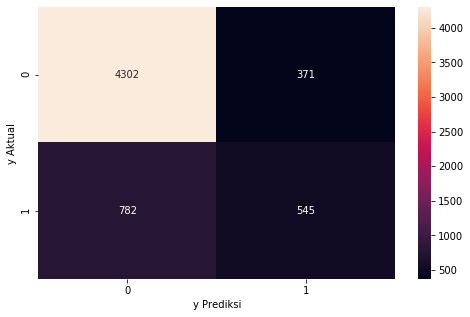

In [43]:
preprocessorlogreg = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), num),
    ('categoric', cat_pipe(encoder='onehot'), cat)
])


pipelinelogreg = Pipeline([
    ('prep', preprocessorlogreg),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])


model7 = RandomizedSearchCV(pipelinelogreg, rsp.logreg_params,scoring='roc_auc' ,cv=4, n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model7.fit(X_train_res, y_train_res)

print(model7.best_params_)
print(model7.score(X_train_res, y_train_res), model7.best_score_, model7.score(X1_test, y1_test))

print(classification_report(y_test,model7.predict(X1_test)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y1_test, model7.predict(X1_test)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

Saya memilih XGBOOST Smote sebagai final model yang akan digunakan

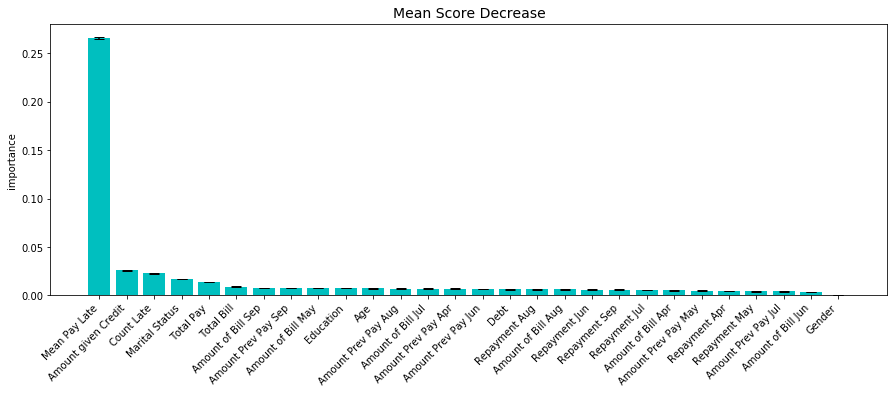

In [44]:
from jcopml.feature_importance import mean_score_decrease

imp = mean_score_decrease(X_train_res, y_train_res, model6, plot=True)

In [45]:
X_t = X_train_res[['Amount given Credit','Marital Status','Total Bill','Mean Pay Late','Repayment Sep','Total Pay']]
# X_t = X_train_res[['Mean Pay Late','Amount given Credit','Marital Status']]
y_t = y_train_res

X_tes = X1_test[['Amount given Credit','Marital Status','Total Bill','Mean Pay Late','Repayment Sep','Total Pay']]
# X_tes = X1_test[['Mean Pay Late','Amount given Credit','Marital Status']]
y_tes = y1_test

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   56.0s finished


{'algo__colsample_bytree': 0.4370861069626263, 'algo__gamma': 8, 'algo__learning_rate': 0.1575132049977973, 'algo__max_depth': 7, 'algo__n_estimators': 182, 'algo__reg_alpha': 0.0025113061677390002, 'algo__reg_lambda': 0.06870614282613305, 'algo__subsample': 0.4668543055695109}
0.9181335966135686 0.8925645128371894 0.7634575543482731
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4673
           1       0.58      0.48      0.52      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.69      0.70      6000
weighted avg       0.80      0.81      0.80      6000



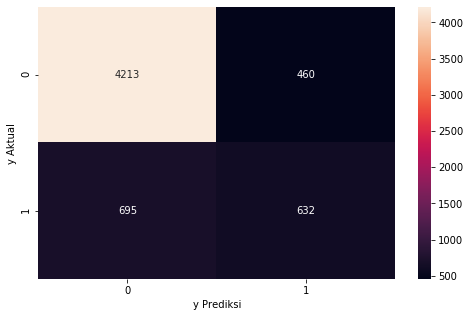

In [46]:
preprocessorxgblast = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['Mean Pay Late','Amount given Credit',
                                             'Total Bill','Repayment Sep','Total Pay']),
    ('categoric', cat_pipe(encoder='onehot'), ['Marital Status'])
])

pipelinexgb = Pipeline([
    ('prep', preprocessorxgblast),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model8 = RandomizedSearchCV(pipelinexgb, rsp.xgb_params, cv=4,scoring='roc_auc', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model8.fit(X_t, y_t)

print(model8.best_params_)
print(model8.score(X_t, y_t), model8.best_score_, model8.score(X_tes, y_tes))

print(classification_report(y_tes,model8.predict(X_tes)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_tes, model8.predict(X_tes)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

In [49]:
model8.best_params_

{'algo__colsample_bytree': 0.4370861069626263,
 'algo__gamma': 8,
 'algo__learning_rate': 0.1575132049977973,
 'algo__max_depth': 7,
 'algo__n_estimators': 182,
 'algo__reg_alpha': 0.0025113061677390002,
 'algo__reg_lambda': 0.06870614282613305,
 'algo__subsample': 0.4668543055695109}

0.8108982932962389 0.7976666666666666
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4673
           1       0.54      0.55      0.55      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.71      0.71      6000
weighted avg       0.80      0.80      0.80      6000



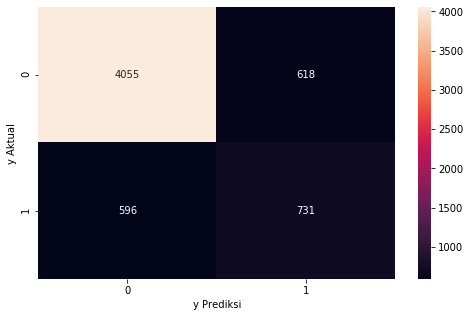

In [81]:
preprocessorxgblast = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['Mean Pay Late','Amount given Credit',
                                             'Total Bill','Repayment Sep','Total Pay']),
    ('categoric', cat_pipe(encoder='onehot'), ['Marital Status'])
])

finalmodel = Pipeline([
    ('prep',preprocessorxgblast), ('algo',XGBClassifier(
        colsample_bytree = 0.4370861069626263,
        gamma = 8,
        learning_rate = 0.05,
        max_depth = 4,
        n_estimators = 182,
        reg_alpha = 0.0025113061677390002,
        reg_lambda = 0.06870614282613305,
        subsample = 0.4668543055695109,
        n_jobs=-1, 
        random_state=42))
])

finalmodel.fit(X_t, y_t)

print(finalmodel.score(X_t, y_t), finalmodel.score(X_tes, y_tes))

print(classification_report(y_tes,finalmodel.predict(X_tes)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_tes, finalmodel.predict(X_tes)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

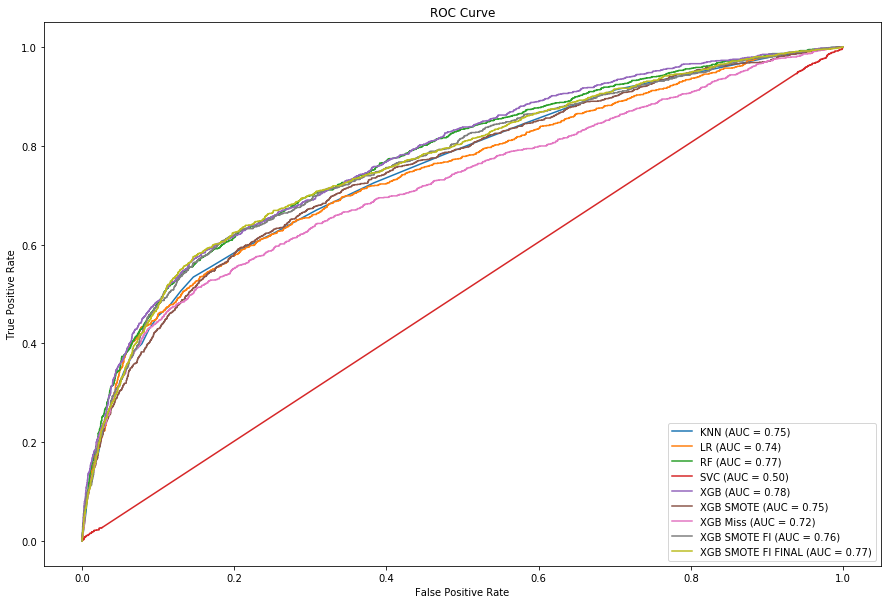

In [82]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_roc_curve, roc_auc_score, roc_curve, f1_score

plt.figure(figsize = (15,10))
ax = plt.gca()

plot_roc_curve(model1, X_test, y_test, ax=ax, name='KNN')
plot_roc_curve(model2, X_test, y_test, ax=ax, name='LR')
plot_roc_curve(model3, X_test, y_test, ax=ax, name='RF')
plot_roc_curve(model4, X_test, y_test, ax=ax, name='SVC')
plot_roc_curve(model5, X_test, y_test, ax=ax, name='XGB')
plot_roc_curve(model6, X1_test, y1_test, ax=ax, name='XGB SMOTE')
plot_roc_curve(model7, X1_test, y1_test, ax=ax, name='XGB Miss')
plot_roc_curve(model8, X_tes, y_tes, ax=ax, name='XGB SMOTE FI')
plot_roc_curve(finalmodel, X_tes, y_tes, ax=ax, name='XGB SMOTE FI FINAL')

plt.title('ROC Curve')
plt.show()

In [86]:
# Saya memilih model RF Smote untuk disimpan

save_model(finalmodel, "finalmodel.pkl")

Model is pickled as model/finalmodel.pkl


Kesimpulan : 

1. Final model yang dipakai adalah model XGBoost dengan Feature Importance yang sudah ditentukan
2. Nilai TP pada final model adalah 731
3. Nilai TN pada final model adalah 4055
4. Nilai FP pada final model adalah 618
5. Nilai FN pada final model adalah 596
6. Nilai recall positive pada final model = TP/TP+FN = 0.55
7. Nilai recall negative pada final model = TN/TN+FP = 0.87
8. Nilai presisi positive pada final model = TP/TP+FP = 0.54
9. Nilai presisi negative pada final model = TN/TN+FN = 0.87
10. Score ROC-AUC pada final model = 0.77
11. Nilai Akurasi pada final model = 0.8